In [113]:
import pandas as pd
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
import numpy as np
from sklearn import ensemble, linear_model, metrics, model_selection, discriminant_analysis, preprocessing, multiclass, svm,neighbors
from sklearn import datasets, linear_model, metrics, model_selection, pipeline, preprocessing, multiclass
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import scipy
import lightgbm as lgbm
import pickle

In [114]:
TRAIN = 'C:\\Users\\krvet\\Documents\\GitHub\\aicrowd_learn_to_smell\\data\\train_df.csv'
VALIDATION = 'C:\\Users\\krvet\\Documents\\GitHub\\aicrowd_learn_to_smell\\data\\validation_df.csv'
HOLD_OUT_DF = 'C:\\Users\\krvet\\Documents\\GitHub\\aicrowd_learn_to_smell\\data\\hold_out_df.csv'
VOCABULARY = 'C:\\Users\\krvet\\Documents\\GitHub\\aicrowd_learn_to_smell\\data\\data_round-3_vocabulary.txt'
DATA = 'C:\\Users\\krvet\\Documents\\GitHub\\aicrowd_learn_to_smell\\data\\train.csv'

In [115]:
train = pd.read_csv(TRAIN)
validation = pd.read_csv(VALIDATION)
hold = pd.read_csv(HOLD_OUT_DF)
data = pd.read_csv(DATA)

In [117]:
data

,SMILES,SENTENCE
0,C/C=C/C(=O)C1CCC(C=C1C)(C)C,"fruity,rose"
1,COC(=O)OC,"fresh,ethereal,fruity"
2,Cc1cc2c([nH]1)cccc2,"resinous,animalic"
3,C1CCCCCCCC(=O)CCCCCCC1,"powdery,musk,animalic"
4,CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C,"coniferous,camphor,fruity"
...,...,...
4311,CCOC(=O)[C@]12CCC[C@@H]2[C@H]2C[C@@H]1CC2,"floral,citrus"
4312,CC1(O)C2(C)CCCC1(C)CC2,"watery,earthy"
4313,C1CC(=N[C@@H]1C(=O)O)O,"sweet,ethereal"
4314,CCCc1c(C)ncc(C)n1,nut


In [118]:
smels = [line.rstrip('\n') for line in open(VOCABULARY)]

In [119]:
def remove_smels(x):
    df = x.copy()
    df['SENTENCE'] = df['SENTENCE'].apply(lambda x: x.split(','))
    df['SENTENCE'] = df['SENTENCE'].apply(lambda x: [j for j in x if j in smels])
    return df

In [120]:
train_true = remove_smels(train)
validation_true = remove_smels(validation)
hold_true = remove_smels(hold)
data_true = remove_smels(data)

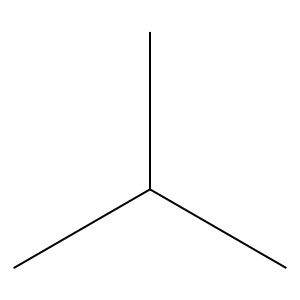

In [8]:
wer = Chem.MolFromSmiles('CC(C)C')
Chem.Draw.MolToImage(wer)

In [9]:
find_counts('CC(C)C', 'CCC')

NameError: name 'find_counts' is not defined

In [121]:
data_true

,SMILES,SENTENCE
0,C/C=C/C(=O)C1CCC(C=C1C)(C)C,"[fruity, rose]"
1,COC(=O)OC,"[fresh, ethereal, fruity]"
2,Cc1cc2c([nH]1)cccc2,"[resinous, animalic]"
3,C1CCCCCCCC(=O)CCCCCCC1,"[powdery, musk, animalic]"
4,CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C,"[camphor, fruity]"
...,...,...
4311,CCOC(=O)[C@]12CCC[C@@H]2[C@H]2C[C@@H]1CC2,"[floral, citrus]"
4312,CC1(O)C2(C)CCCC1(C)CC2,"[watery, earthy]"
4313,C1CC(=N[C@@H]1C(=O)O)O,"[sweet, ethereal]"
4314,CCCc1c(C)ncc(C)n1,[nut]


In [122]:
def find_counts(s, m):
    template = Chem.MolFromSmiles(s)
    return len(template.GetSubstructMatches(Chem.MolFromSmiles(m)))

In [123]:
def find_arr(x, str):
    a = 0
    for i in x:
        if i == str:
            a+=1
    return a

In [124]:
def find_rings_arr(s, arr=False):
    template = Chem.MolFromSmiles(s)
    ri = template.GetRingInfo().BondRings()
    a = 0
    n = 0
    for mol in ri:
        arom = True
        for id in mol:
            if template.GetBondWithIdx(id).GetIsAromatic():
                arom &= False
        if arom:
            a += 1
        else:
            n += 1    
    if arr:
        return n
    else:
        return a

In [125]:
def find_pattern(data):
    df = data.copy()
    df['arr C'] = df['SMILES'].apply(lambda x: len(Chem.MolFromSmiles(x).GetSubstructMatches(Chem.MolFromSmarts('c'))))
    df['C'] = df['SMILES'].apply(lambda x: find_counts(x, 'C')) - df['arr C']
    df['C4'] = df['SMILES'].apply(lambda x: find_counts(x, 'CC(C)(C)C'))
    df['C3'] = df['SMILES'].apply(lambda x: find_counts(x, 'CC(C)C')) - 4 * df['C4']
    df['C2'] = df['SMILES'].apply(lambda x: find_counts(x, 'CCC')) - 6 * df['C4'] - 3 * df['C3']
    df['2_C'] = df['SMILES'].apply(lambda x: find_counts(x, 'C=C'))
    df['3_C'] = df['SMILES'].apply(lambda x: find_counts(x, 'C#C'))
    df['ester'] = df['SMILES'].apply(lambda x: find_counts(x, 'OC(=O)'))
    df['ether'] = df['SMILES'].apply(lambda x: find_counts(x, 'COC'))  - df['ester']
    df['ketone'] = df['SMILES'].apply(lambda x: find_counts(x, 'CC(=O)C'))
    df['aldehyde'] = df['SMILES'].apply(lambda x: find_counts(x, 'C(=O)')) - df['ester'] - df['ketone']
    df['alchogol'] = df['SMILES'].apply(lambda x: find_counts(x, 'C(O)') - 2*find_counts(x, 'COC'))
    df['arr S'] = df['SMILES'].apply(lambda x: len(Chem.MolFromSmiles(x).GetSubstructMatches(Chem.MolFromSmarts('s'))))
    df['S'] = df['SMILES'].apply(lambda x: find_counts(x, 'S')) - df['arr S']
    df['arr P'] = df['SMILES'].apply(lambda x: len(Chem.MolFromSmiles(x).GetSubstructMatches(Chem.MolFromSmarts('p'))))
    df['P'] = df['SMILES'].apply(lambda x: find_counts(x, 'P')) - df['arr P']
    df['arr N'] = df['SMILES'].apply(lambda x: len(Chem.MolFromSmiles(x).GetSubstructMatches(Chem.MolFromSmarts('n'))))
    df['N'] = df['SMILES'].apply(lambda x: find_counts(x, 'N')) - df['arr N']
    df['F'] = df['SMILES'].apply(lambda x: find_counts(x, 'F'))
    df['Cl'] = df['SMILES'].apply(lambda x: find_counts(x, 'Cl'))
    df['Br'] = df['SMILES'].apply(lambda x: find_counts(x, 'Br'))
    df['Rings'] = df['SMILES'].apply(lambda x: find_rings_arr(x))
    df['Arr Rings'] = df['SMILES'].apply(lambda x: find_rings_arr(x, True))
    df['Arr Rings N'] = df['SMILES'].apply(lambda x: find_arr(x, 'n'))
    df['Arr Rings O'] = df['SMILES'].apply(lambda x: find_arr(x, 'o'))
    df['Arr Rings S'] = df['SMILES'].apply(lambda x: find_arr(x, 's'))
    
    df['ExactMolWt'] = df['SMILES'].apply(lambda x: Descriptors.ExactMolWt(Chem.MolFromSmiles(x)))
    df['TPSA'] = df['SMILES'].apply(lambda x: Descriptors.TPSA(Chem.MolFromSmiles(x)))
    df['MolLogP'] = df['SMILES'].apply(lambda x: Descriptors.MolLogP(Chem.MolFromSmiles(x)))

    df['HeavyAtomCount'] = df['SMILES'].apply(lambda x: Descriptors.HeavyAtomCount(Chem.MolFromSmiles(x)))
    df['HeavyAtomMolWt'] = df['SMILES'].apply(lambda x: Descriptors.HeavyAtomMolWt(Chem.MolFromSmiles(x)))
    df['NHOHCount'] = df['SMILES'].apply(lambda x: Descriptors.NHOHCount(Chem.MolFromSmiles(x)))
    df['NOCount'] = df['SMILES'].apply(lambda x: Descriptors.NOCount(Chem.MolFromSmiles(x)))
    df['NumHAcceptors'] = df['SMILES'].apply(lambda x: Descriptors.NumHAcceptors(Chem.MolFromSmiles(x)))
    df['NumHDonors'] = df['SMILES'].apply(lambda x: Descriptors.NumHDonors(Chem.MolFromSmiles(x)))
    df['NumHeteroatoms'] = df['SMILES'].apply(lambda x: Descriptors.NumHeteroatoms(Chem.MolFromSmiles(x)))
    df['NumRotatableBonds'] = df['SMILES'].apply(lambda x: Descriptors.NumRotatableBonds(Chem.MolFromSmiles(x)))
    df['NumValenceElectrons'] = df['SMILES'].apply(lambda x: Descriptors.NumValenceElectrons(Chem.MolFromSmiles(x)))
    df['NumAromaticRings'] = df['SMILES'].apply(lambda x: Descriptors.NumAromaticRings(Chem.MolFromSmiles(x)))
    df['NumSaturatedRings'] = df['SMILES'].apply(lambda x: Descriptors.NumSaturatedRings(Chem.MolFromSmiles(x)))
    df['NumAliphaticRings'] = df['SMILES'].apply(lambda x: Descriptors.NumAliphaticRings(Chem.MolFromSmiles(x)))
    df['NumAliphaticCarbocycles'] = df['SMILES'].apply(lambda x: Descriptors.NumAliphaticCarbocycles(Chem.MolFromSmiles(x)))
    df['NumAliphaticHeterocycles'] = df['SMILES'].apply(lambda x: Descriptors.NumAliphaticHeterocycles(Chem.MolFromSmiles(x)))
    df['NumAromaticCarbocycles'] = df['SMILES'].apply(lambda x: Descriptors.NumAromaticCarbocycles(Chem.MolFromSmiles(x)))
    df['NumAromaticHeterocycles'] = df['SMILES'].apply(lambda x: Descriptors.NumAromaticHeterocycles(Chem.MolFromSmiles(x)))
    df['NumSaturatedHeterocycles'] = df['SMILES'].apply(lambda x: Descriptors.NumSaturatedHeterocycles(Chem.MolFromSmiles(x)))
    df['NumSaturatedCarbocycles'] = df['SMILES'].apply(lambda x: Descriptors.NumSaturatedCarbocycles(Chem.MolFromSmiles(x)))
    return df

In [126]:
train_count = find_pattern(train_true)
validation_count = find_pattern(validation_true)
hold_count = find_pattern(hold_true)
data_count = find_pattern(data_true)

In [127]:
data_count

,SMILES,SENTENCE,arr C,C,C4,C3,C2,2_C,3_C,ester,...,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumAromaticHeterocycles,NumSaturatedHeterocycles,NumSaturatedCarbocycles
0,C/C=C/C(=O)C1CCC(C=C1C)(C)C,"[fruity, rose]",0,13,1,1,4,2,0,0,...,78,0,0,1,1,0,0,0,0,0
1,COC(=O)OC,"[fresh, ethereal, fruity]",0,3,0,0,0,0,0,2,...,36,0,0,0,0,0,0,0,0,0
2,Cc1cc2c([nH]1)cccc2,"[resinous, animalic]",8,1,0,0,0,0,0,0,...,50,2,0,0,0,0,1,1,0,0
3,C1CCCCCCCC(=O)CCCCCCC1,"[powdery, musk, animalic]",0,16,0,0,16,0,0,0,...,100,0,1,1,1,0,0,0,0,1
4,CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C,"[camphor, fruity]",0,15,2,2,5,0,0,1,...,98,0,2,2,2,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4311,CCOC(=O)[C@]12CCC[C@@H]2[C@H]2C[C@@H]1CC2,"[floral, citrus]",0,13,1,3,6,0,0,1,...,84,0,3,3,3,0,0,0,0,3
4312,CC1(O)C2(C)CCCC1(C)CC2,"[watery, earthy]",0,11,2,1,5,0,0,0,...,70,0,2,2,2,0,0,0,0,2
4313,C1CC(=N[C@@H]1C(=O)O)O,"[sweet, ethereal]",0,5,0,0,3,0,0,1,...,50,0,0,1,0,1,0,0,0,0
4314,CCCc1c(C)ncc(C)n1,[nut],4,5,0,0,2,0,0,0,...,60,1,0,0,0,0,0,1,0,0


In [17]:
train_count['C2'].min()

-1

# Обработка данных

In [132]:
Y_train = data_count['SENTENCE'].copy()
data_train = data_count.copy()
X_train = data_train.drop(['SMILES', 'SENTENCE'], 1)

In [133]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = np.sum(np.abs(y_true * y_pred), axis=-1)
    sums = np.sum(np.abs(y_true) + np.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sums - intersection + smooth)
    return (1 - jac) * smooth

In [134]:
lb = preprocessing.MultiLabelBinarizer(classes = smels)
train_ans = pd.DataFrame(lb.fit_transform(Y_train), columns = smels)

# Градиент БУСТ

In [189]:
model = multiclass.OneVsRestClassifier(estimator=ensemble.GradientBoostingClassifier(n_estimators = 1000))

In [190]:
model.fit(X_train, train_ans)

OneVsRestClassifier(estimator=GradientBoostingClassifier(n_estimators=1000))

In [191]:
output = model.predict_proba(X_train)
a = pd.DataFrame(output, columns = smels)
for i in range(len(a)):
    threshold = a.iloc[i].sort_values()[-3]
    a.iloc[i] = a.iloc[i].apply(lambda x : 0 if x < threshold else 1)

In [192]:
jaccard_distance(np.array(train_ans), np.array(a)).mean()

1.7731642754356105

In [193]:
output = model.predict(X_train)

In [194]:
output

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [195]:
jaccard_distance(np.array(train_ans),output).mean()

1.1848196093495318

In [199]:
metrics.accuracy_score(np.array(train_ans),output)

0.4526261585993821

In [138]:
pickle.dump(model2, open('C:\\Users\\krvet\\Documents\\GitHub\\aicrowd_learn_to_smell\\data\\modelRandomForestClassifier', 'wb'))

In [206]:
train_count.to_csv('C:\\Users\\krvet\\Documents\\GitHub\\aicrowd_learn_to_smell\\data\\train_count.csv')
validation_count.to_csv('C:\\Users\\krvet\\Documents\\GitHub\\aicrowd_learn_to_smell\\data\\validation_count.csv')
hold_count.to_csv('C:\\Users\\krvet\\Documents\\GitHub\\aicrowd_learn_to_smell\\data\\hold_count.csv')

In [203]:
a = hold_count


Y = a['SENTENCE'].copy()
data = a.copy()
X = a.drop(['SMILES','Unnamed: 0', 'SENTENCE'], 1)
ans = lb.fit_transform(Y)
output = model.predict(X)
jaccard_distance(ans,output).mean()

3.030423649766311

In [204]:
metrics.accuracy_score(ans,output)

0.08045977011494253

# ЛЕС

In [135]:
model2 = multiclass.OneVsRestClassifier(estimator=ensemble.RandomForestClassifier(n_estimators = 220, criterion = 'entropy', 
                                                                                 random_state = 42, n_jobs = -1))
model2.fit(X_train, train_ans)

OneVsRestClassifier(estimator=RandomForestClassifier(criterion='entropy',
                                                     n_estimators=220,
                                                     n_jobs=-1,
                                                     random_state=42))

In [136]:
a = hold_count


Y = a['SENTENCE'].copy()
data = a.copy()
X = a.drop(['SMILES','Unnamed: 0', 'SENTENCE'], 1)
ans = lb.fit_transform(Y)
output = model2.predict(X)
jaccard_distance(ans,output).mean()

1.2150415043724083

In [137]:
metrics.accuracy_score(ans,output)

0.5057471264367817

# lightgbm.LGBMRegressor

In [24]:
model3 = multiclass.OneVsRestClassifier(estimator=lgbm.LGBMRegressor(n_estimators = 1000))
model3.fit(X_train, train_ans)

OneVsRestClassifier(estimator=LGBMRegressor(n_estimators=1000))

In [25]:
a = hold_count


Y = a['SENTENCE'].copy()
data = a.copy()
X = a.drop(['SMILES','Unnamed: 0', 'SENTENCE'], 1)
ans = lb.fit_transform(Y)
output = model3.predict(X)
jaccard_distance(ans,output).mean()

3.057982256136503

In [26]:
metrics.accuracy_score(ans,output)

0.08045977011494253

# sklearn.svm.SVC

In [23]:
model4 = multiclass.OneVsRestClassifier(estimator=svm.SVC())
model4.fit(X_train, train_ans)
a = hold_count


Y = a['SENTENCE'].copy()
data = a.copy()
X = a.drop(['SMILES','Unnamed: 0', 'SENTENCE'], 1)
ans = lb.fit_transform(Y)
output = model4.predict(X)
print(jaccard_distance(ans,output).mean())
print(metrics.accuracy_score(ans,output))

2.624122178636144
0.034482758620689655


# KNN

In [92]:
model5 = multiclass.OneVsRestClassifier(estimator=neighbors.KNeighborsClassifier( n_jobs=-1,
                                                                                     n_neighbors = 100, 
                                                                                     weights= 'distance',
                                                                                     algorithm = 'kd_tree') )
model5.fit(X_train, train_ans)
a = hold_count


Y = a['SENTENCE'].copy()
data = a.copy()
X = a.drop(['SMILES','Unnamed: 0', 'SENTENCE'], 1)
ans = lb.fit_transform(Y)
output = model5.predict(X)
print(jaccard_distance(ans,output).mean())
print(metrics.accuracy_score(ans,output))

NameError: name 'X_train' is not defined

# Try with words

In [93]:
lb = preprocessing.MultiLabelBinarizer(classes = smels)
train_ans = pd.DataFrame(lb.fit_transform(train_true['SENTENCE']), columns = smels)
train_ans

,aldehydic,almond,ambery,animalic,anisic,apple,balsamic,banana,berry,blackcurrant,...,spicy,sulfuric,sweet,tropicalfruit,vanilla,vegetable,violetflower,watery,waxy,woody
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3879,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3880,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3881,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3882,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [107]:
model = multiclass.OneVsRestClassifier(estimator=lgbm.LGBMRegressor(n_estimators = 1000) )

In [108]:
def split(a):
    df = a.copy()
    for i in range(len(df)):
        q = df[i]
        df[i] = ''
        for w in range(len(q)):
            for e in range(w, len(q)): 
                  df[i] += ' ' + q[w:e] 
    return df


In [109]:
tfidf_pipe = pipeline.Pipeline(steps = [('vectorizer', TfidfVectorizer(min_df = 3)), 
                                        ('classifier', model)])

In [110]:
tr_qw = pd.DataFrame(lb.fit_transform(train_true['SENTENCE']), columns = smels)

In [111]:
tfidf_pipe.fit(split(train_true['SMILES']), train_ans)

Pipeline(steps=[('vectorizer', TfidfVectorizer(min_df=3)),
                ('classifier',
                 OneVsRestClassifier(estimator=LGBMRegressor(n_estimators=1000)))])

In [112]:
output = tfidf_pipe.predict(split(hold_true['SMILES']))
ans = lb.fit_transform(hold_true['SENTENCE'])
print(jaccard_distance(ans,output).mean())
print(metrics.accuracy_score(ans,output))

3.11622914794184
0.06896551724137931
